### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [99]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [100]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [101]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [102]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [103]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

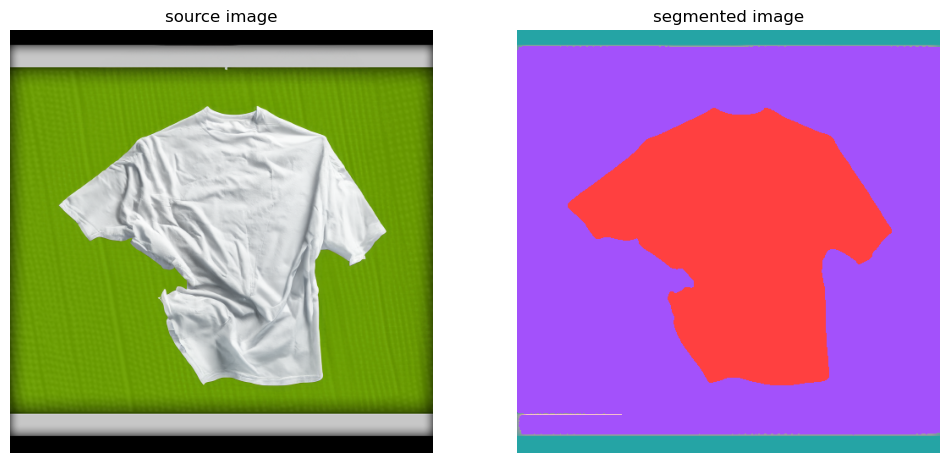

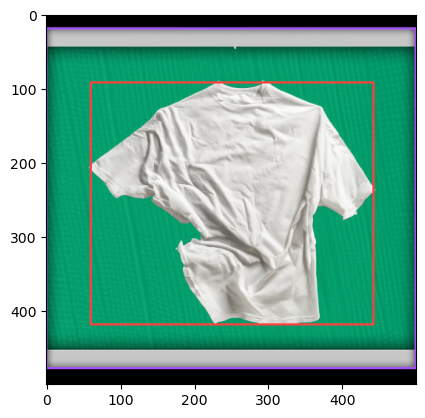

In [108]:
relative_path = get_training_data_path('production', 'tshirt')

file_names = []


# Iterate over files in the current directory
for i in range(0, 1):
    fullpath = os.path.join(relative_path, '20240526_154948.png')

    orig_image = Image.open(fullpath)
    orig_image = orig_image.rotate(0)
    #image = erase_generator(path=fullpath)
    n_image = np.array(orig_image)
    # Convert image to YCrCb color space, then apply blurring and shadow removal
    image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)


    blurred_image = cv2.medianBlur(image_ycrcb, 5)
    processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

    # Generate masks and filter them
    masks = mask_generator.generate(blurred_image)
    cleaned_masks = [mask for mask in masks if mask['area'] > 25000]

    # Annotation of the image
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
    detections = sv.Detections.from_sam(sam_result=cleaned_masks)
    annotated_image = mask_annotator.annotate(scene=processed_image.copy(), detections=detections)
    
    # Displaying images
    sv.plot_images_grid(
        images=[n_image, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

    # Bounding box annotation on the original image for consistency
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    final_annotated_image = bounding_box_annotator.annotate(
        scene=orig_image, detections=detections)

    plt.imshow(final_annotated_image)

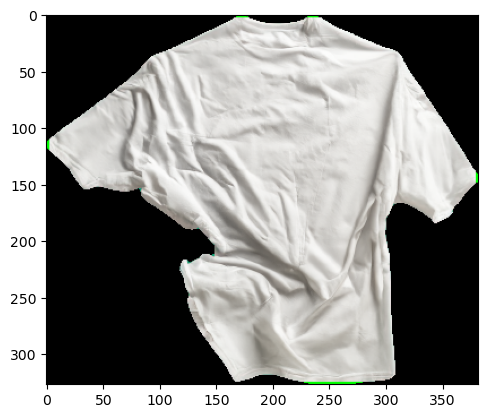

In [109]:
masks_cleaned = []
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 200000):
        #print(mask['area'])
        masks_cleaned.append(mask)

masked_image = n_image
x, y, w, h = cleaned_masks[0]['bbox']
cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)
cropped_image = masked_image[y:y+h, x:x+w]


plt.imshow(cropped_image)

cropped_mask = cleaned_masks[0]['segmentation'][y:y+h,x:x+w]
cropped_mask = cropped_mask.astype(np.uint8) * 255
masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=cropped_mask)

plt.imshow(masked_image)

In [ ]:
def get_center_of_mass(mask):

    # Ensure mask is in the correct format (uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Calculate the center of mass
    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
    else:
        cx, cy = 0, 0  # Set the center to (0, 0) if the mass is zero

    return np.array([cx, cy])


def find_symmetry_line(edge_points):

    data_pts = np.array(edge_points, dtype=np.float32)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=np.array([]))
    # The first eigenvector corresponds to the principal axis
    p1 = (int(mean[0, 0] - 200 * eigenvectors[0, 0]), int(mean[0, 1] - 200 * eigenvectors[0, 1]))
    p2 = (int(mean[0, 0] + 200 * eigenvectors[0, 0]), int(mean[0, 1] + 200 * eigenvectors[0, 1]))

    # Calculate the angle in degrees
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    angle_deg = np.degrees(angle_rad)
    print(angle)
    return p1, p2

In [118]:
def compute_lines(cropped_mask):

    mask_colored = cv2.cvtColor(cropped_mask, cv2.COLOR_GRAY2BGR)

    center_of_mass = get_center_of_mass(cropped_mask)

    center_of_mass[0] = center_of_mass[0] + 50
    center_of_mass[1] = center_of_mass[1] + 50


    blurred_image = mask_colored.copy()

    # Desired dimensions
    desired_width = 500
    desired_height = 350

    # Calculate the amount of padding needed
    padding_right = desired_width - blurred_image.shape[1]
    padding_top = desired_height - blurred_image.shape[0]

    # Add padding to the right side of the mask
    blurred_image = cv2.copyMakeBorder(blurred_image, 
                                    top=50, 
                                    bottom=50, 
                                    left=50, 
                                    right=50, 
                                    borderType=cv2.BORDER_CONSTANT, 
                                    value=0)  # Value 0 for black padding


    blurred_image = cv2.blur(blurred_image, (11,11), 21)

    # Convert to grayscale
    gray = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection (Canny)
    edges = cv2.Canny(gray, 0, 200, apertureSize=5)

    # # Step 2: Extract edge points
    edge_points = np.column_stack(np.where(edges > 0))


    #plt.imshow(edges)
    #p1, p2 = find_symmetry_line(edge_points)


    width, height = blurred_image.shape[1], blurred_image.shape[0]

    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=50) #cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=284, maxLineGap=250)
    #print(len(lines))
    # Initialize votes
    mylines = []
    votes = {}
    if lines is not None:
        for line in lines:
            rho, theta = line[0]

            # a = np.cos(theta)
            # b = np.sin(theta)
            # x0 = a * rho
            # y0 = b * rho
            # x1 = int(x0 + 1000 * (-b))
            # y1 = int(y0 + 1000 * (a))
            # x2 = int(x0 - 1000 * (-b))
            # y2 = int(y0 - 1000 * (a))
            
            # cv2.line(edges, (x1, y1), (x2, y2), (255, 255, 255), 2)
            # Calculate the length of the line
            line_length = np.abs(rho)
            # Accumulate votes for theta values weighted by line length
            if theta not in votes:
                votes[theta] = line_length
            else:
                votes[theta] += line_length

            
            # Visualize the lines found in green color
         

    cx = center_of_mass[0]
    cy = center_of_mass[1]

    # Find the direction with the highest number of votes
    dominant_direction = max(votes, key=votes.get)
    # Draw the dominant direction line
    a = np.cos(dominant_direction)
    b = np.sin(dominant_direction)
    x0 = a * rho
    y0 = b * rho
    x1 = int(cx + 1000 * (-b))
    y1 = int(cy + 1000 * (a))
    x2 = int(cx - 1000 * (-b))
    y2 = int(cy - 1000 * (a))
    cv2.line(edges, (x1, y1), (x2, y2), (255, 255, 255), 2)
    dominant_direction = np.degrees(dominant_direction)
    print("Dominant Direction (in deg):", dominant_direction)


    cv2.circle(blurred_image, (center_of_mass[0], center_of_mass[1]), 15, (255,0,255))


    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), dominant_direction, 1)
    test = cv2.warpAffine(blurred_image, rotation_matrix, (width, height))
    
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.imshow(edges)
    plt.title('Rotated Image')
    plt.axis('off')


    plt.subplot(122)
    plt.imshow(test)
    plt.title('Rotated Image')
    plt.axis('off')

    plt.show()



Dominant Direction (in deg): 178.99998


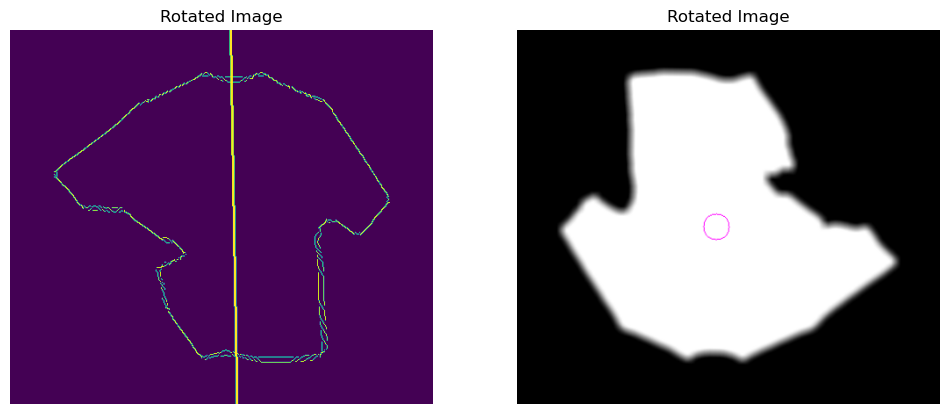

Dominant Direction (in deg): 135.99998


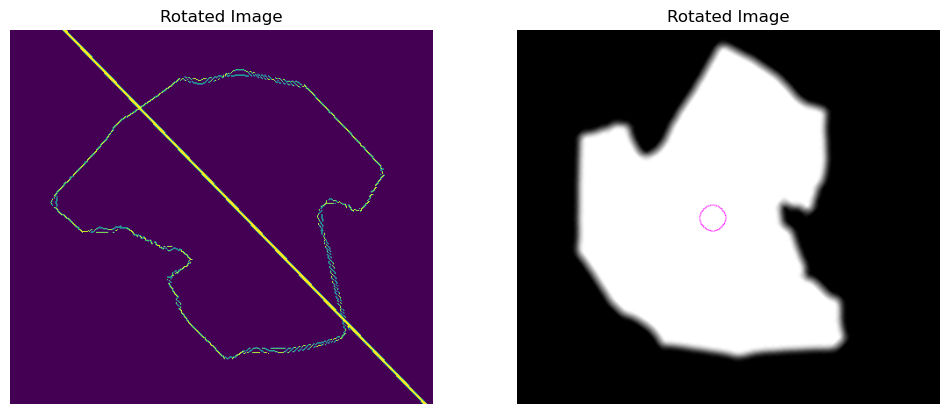

Dominant Direction (in deg): 124.99999


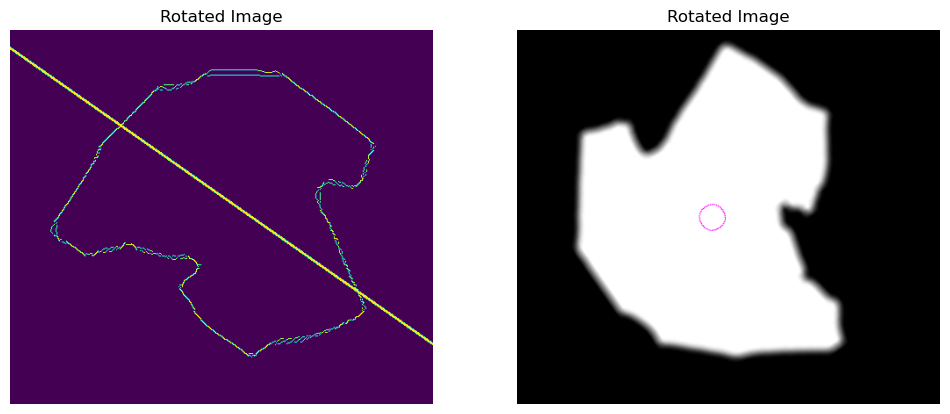

Dominant Direction (in deg): 149.99998


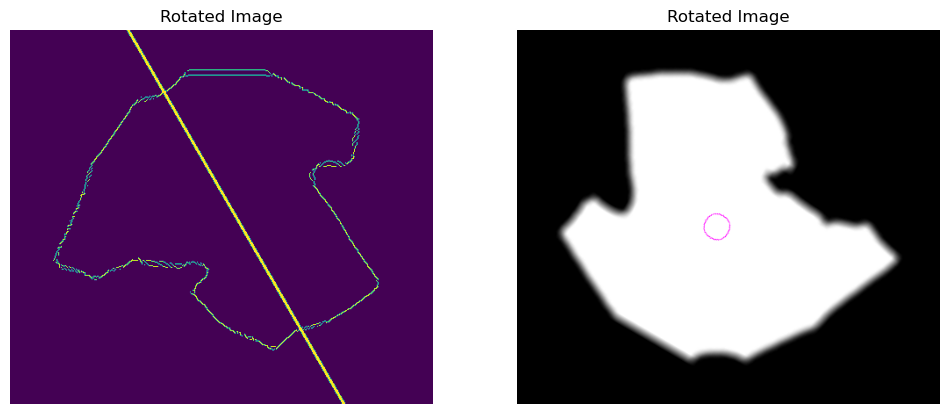

Dominant Direction (in deg): 135.0


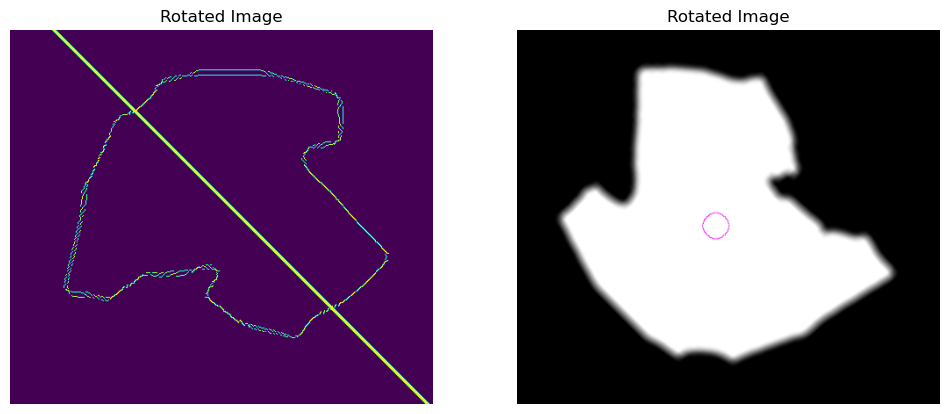

Dominant Direction (in deg): 45.0


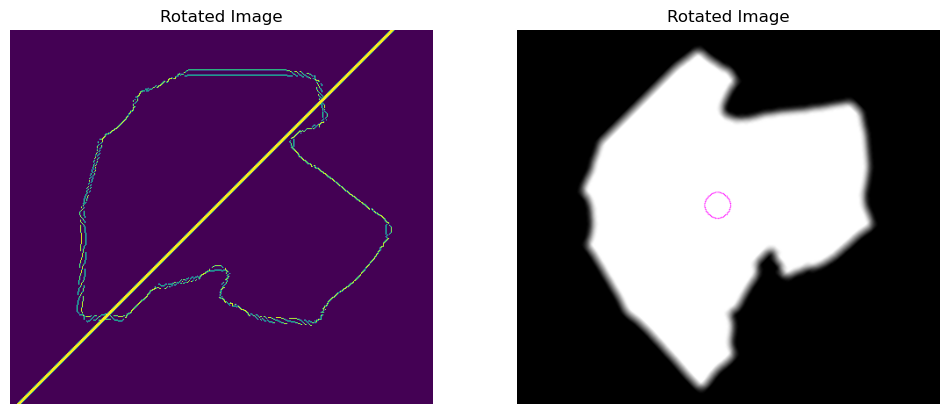

Dominant Direction (in deg): 33.0


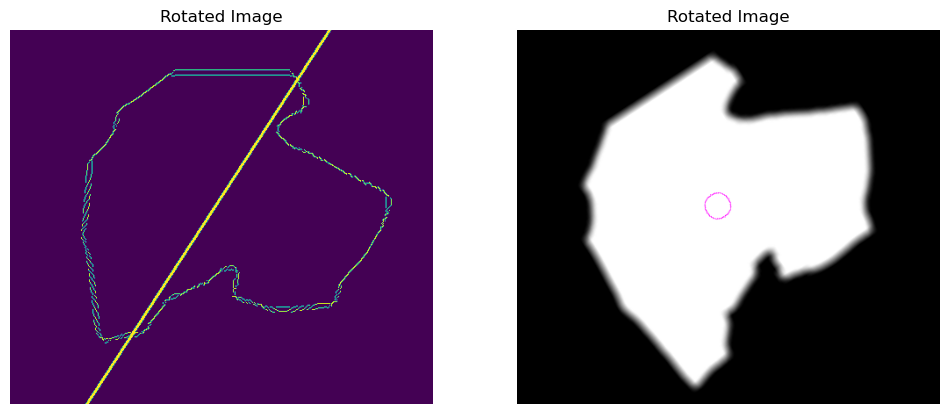

Dominant Direction (in deg): 53.999996


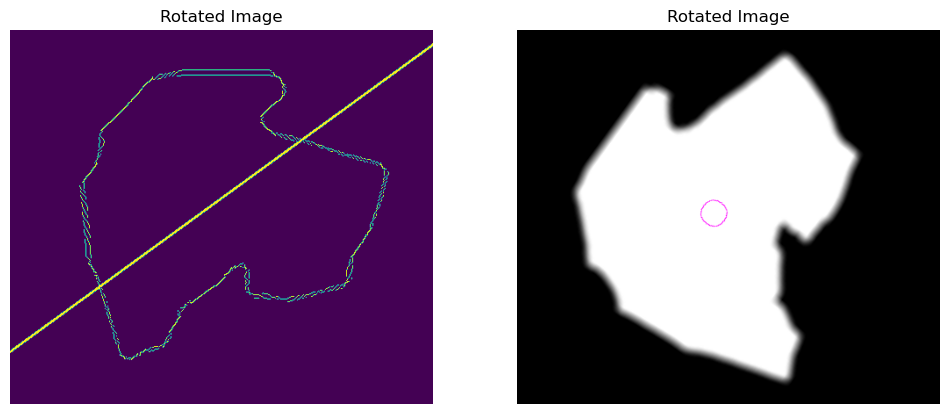

Dominant Direction (in deg): 45.999996


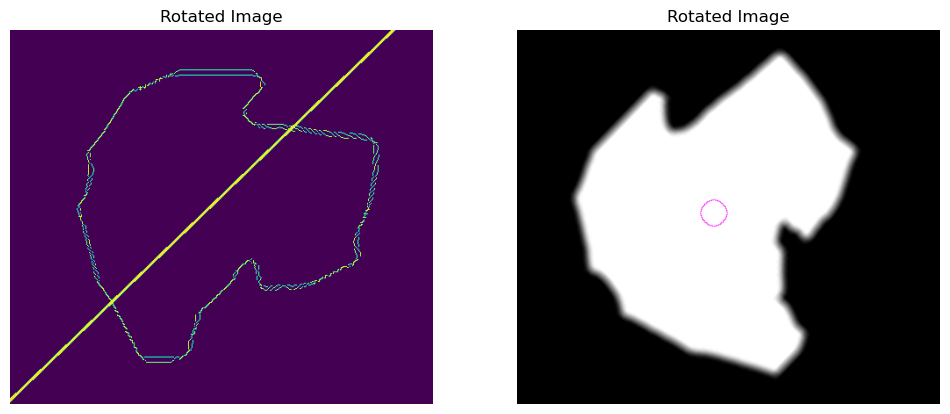

Dominant Direction (in deg): 54.999996


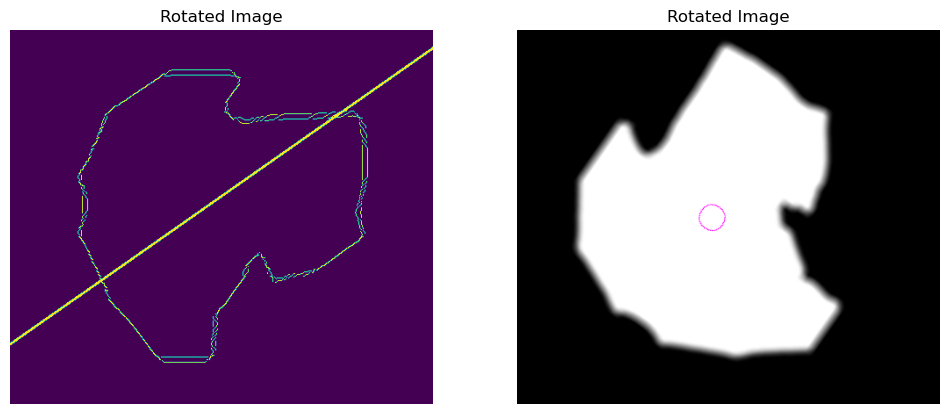

Dominant Direction (in deg): 90.0


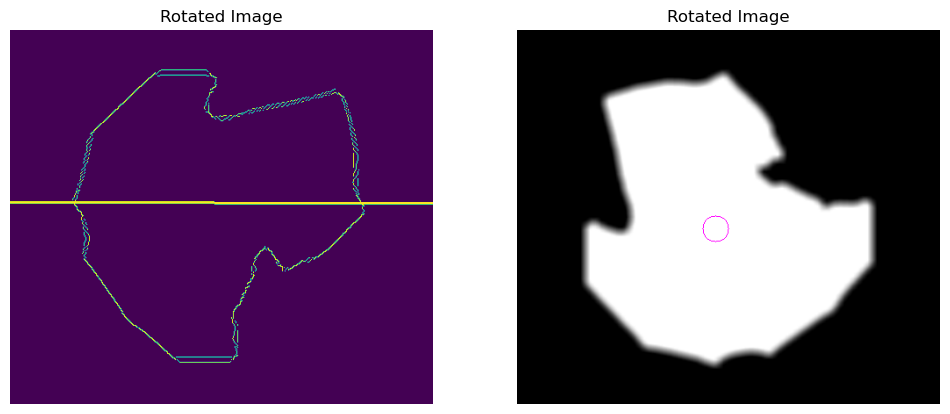

Dominant Direction (in deg): 89.0


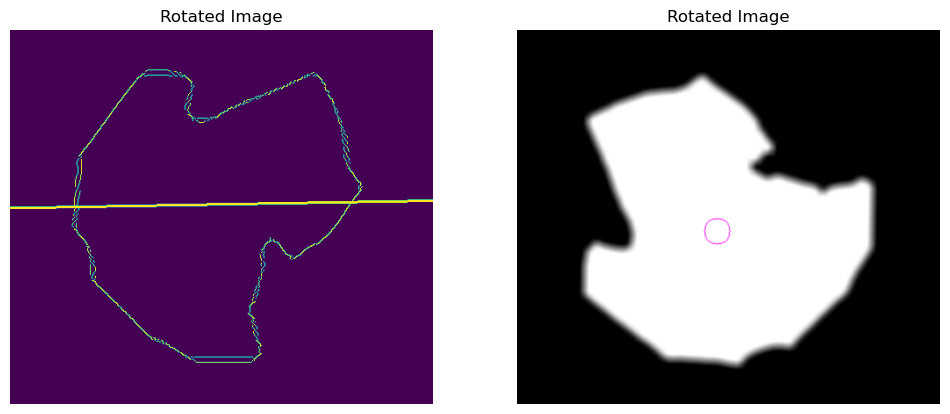

Dominant Direction (in deg): 90.0


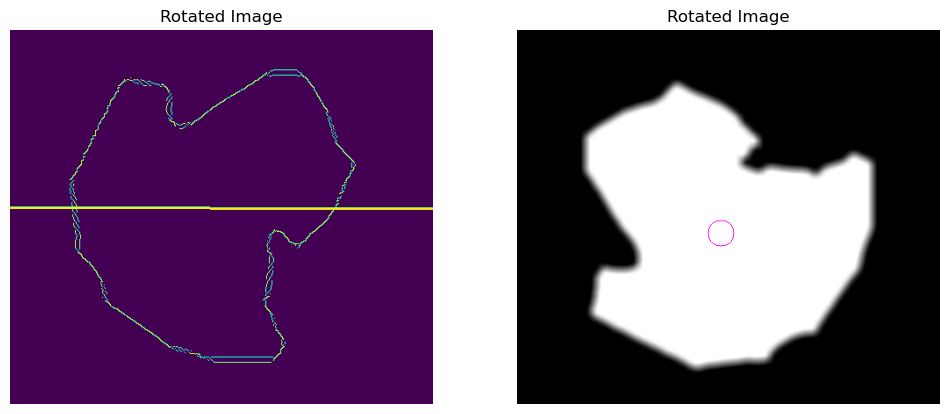

Dominant Direction (in deg): 89.0


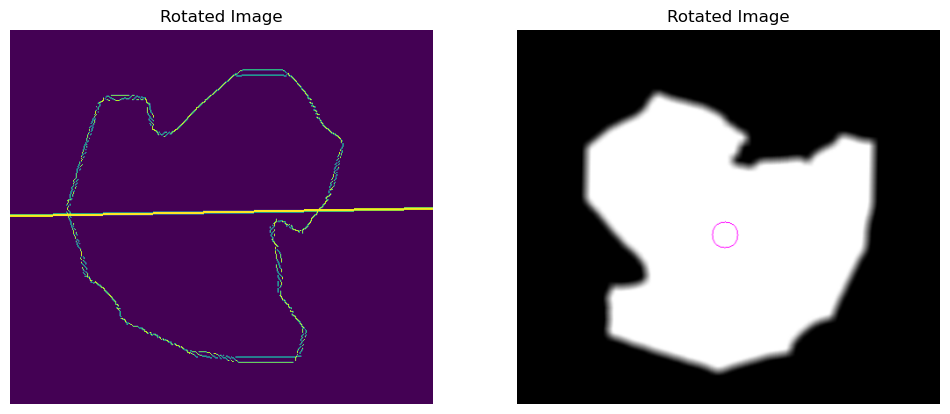

Dominant Direction (in deg): 92.99999


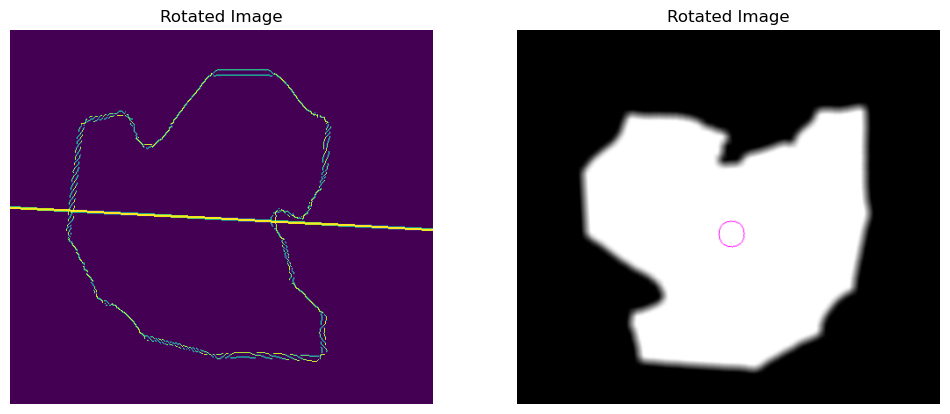

Dominant Direction (in deg): 28.999998


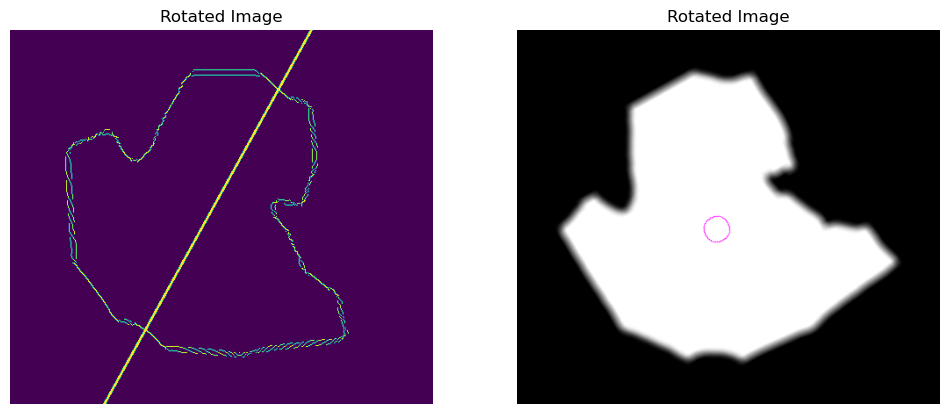

Dominant Direction (in deg): 72.0


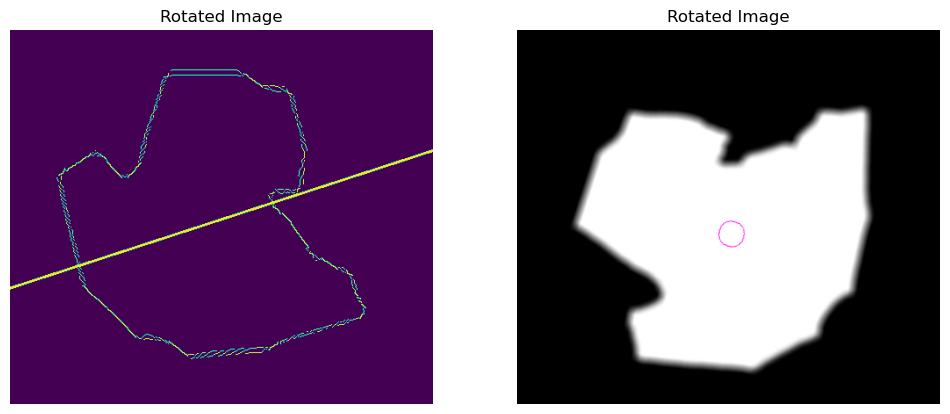

Dominant Direction (in deg): 61.0


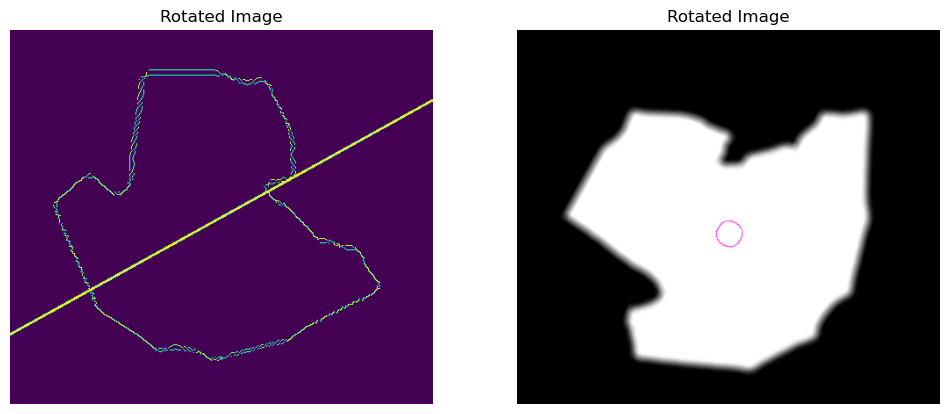

Dominant Direction (in deg): 50.999996


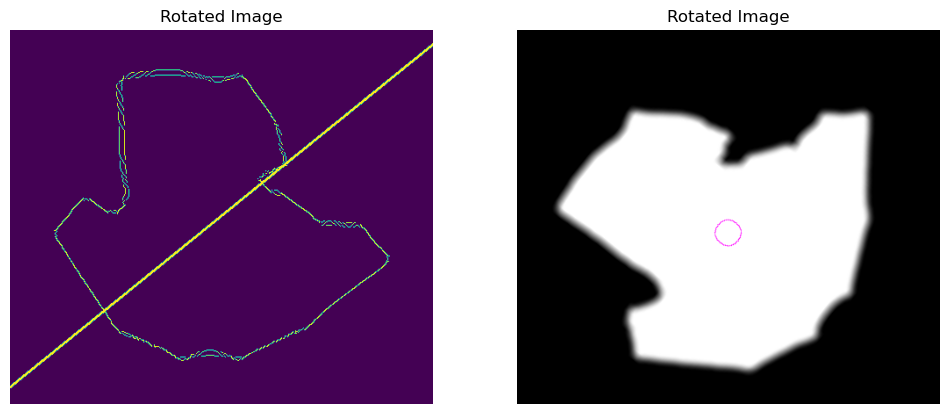

Dominant Direction (in deg): 39.999996


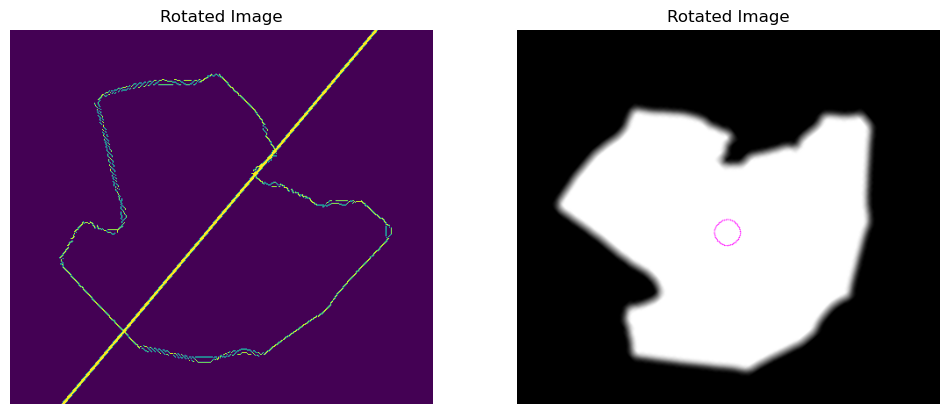

Dominant Direction (in deg): 89.0


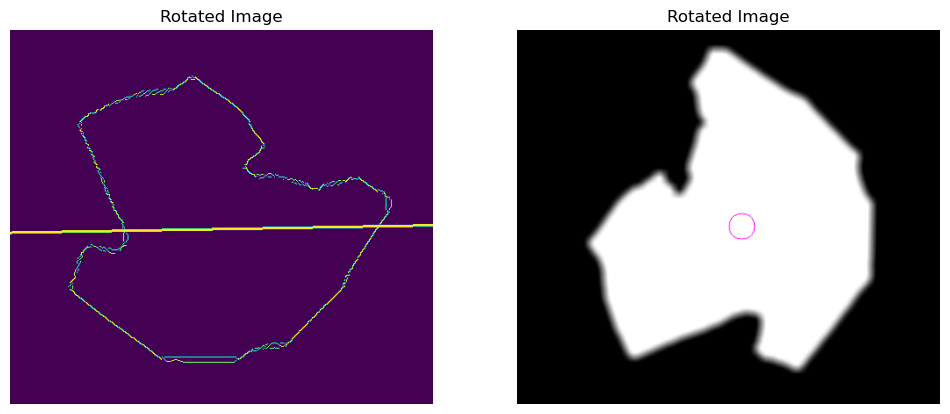

Dominant Direction (in deg): 89.0


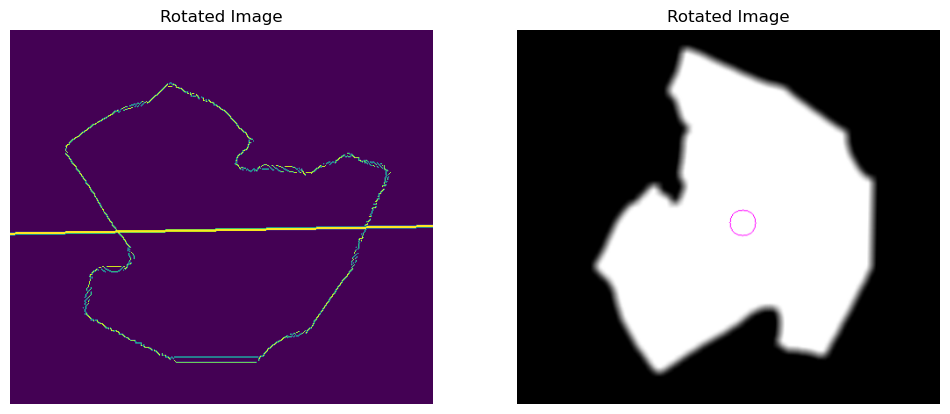

Dominant Direction (in deg): 89.0


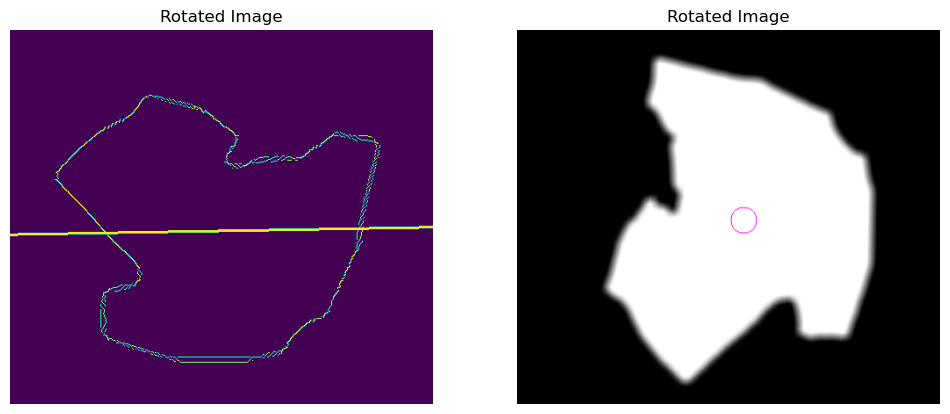

Dominant Direction (in deg): 89.0


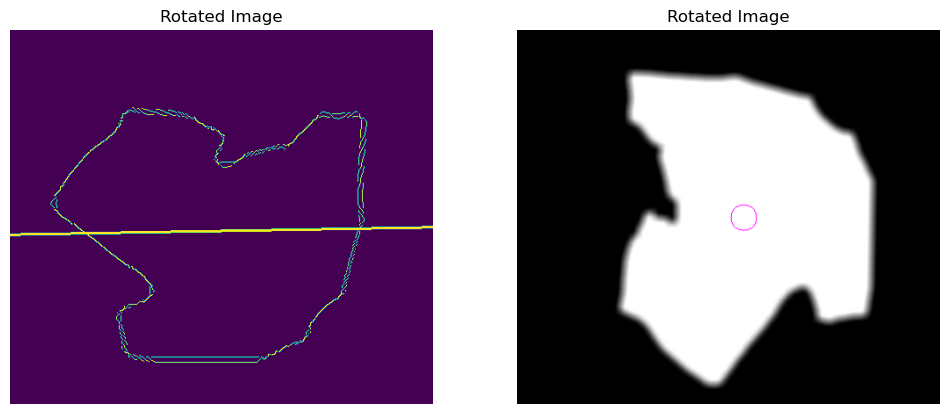

Dominant Direction (in deg): 89.0


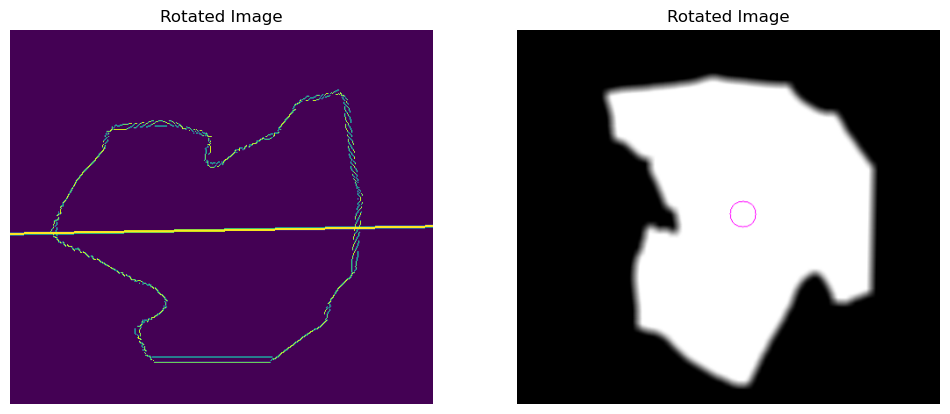

Dominant Direction (in deg): 89.0


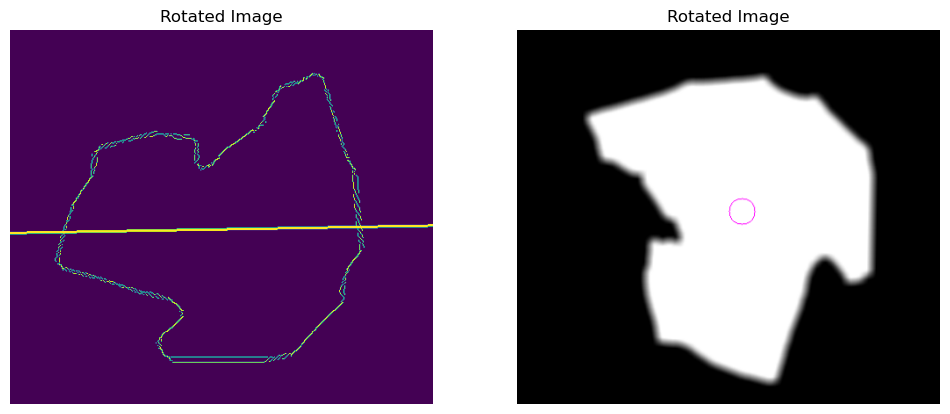

Dominant Direction (in deg): 89.0


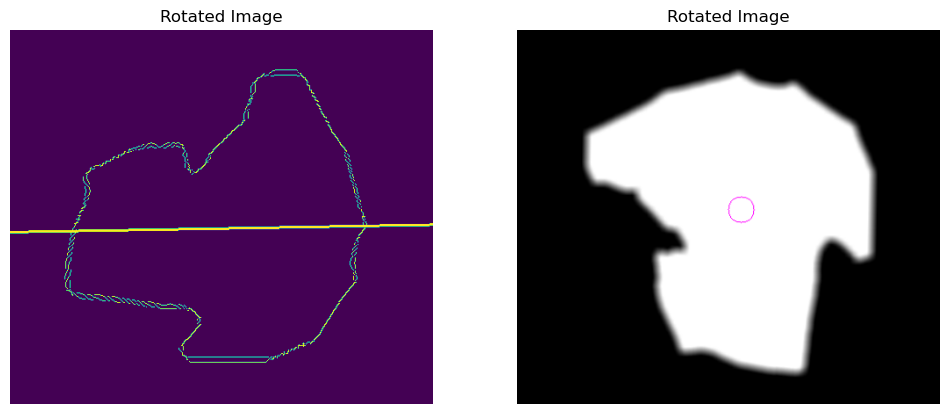

Dominant Direction (in deg): 90.0


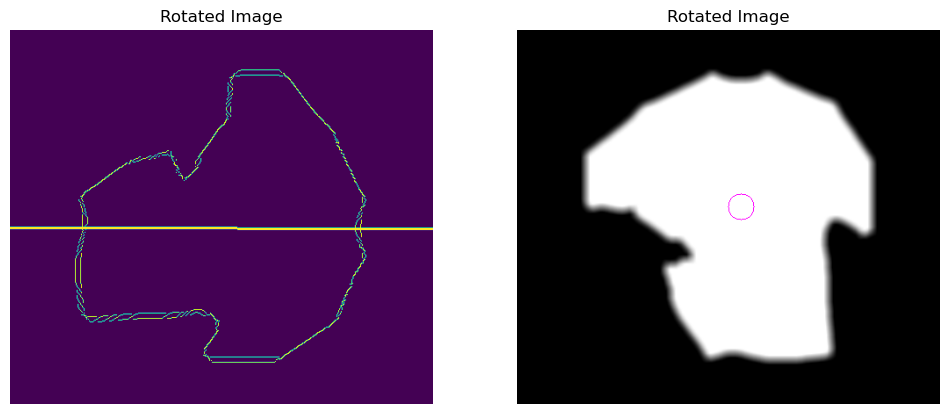

Dominant Direction (in deg): 90.0


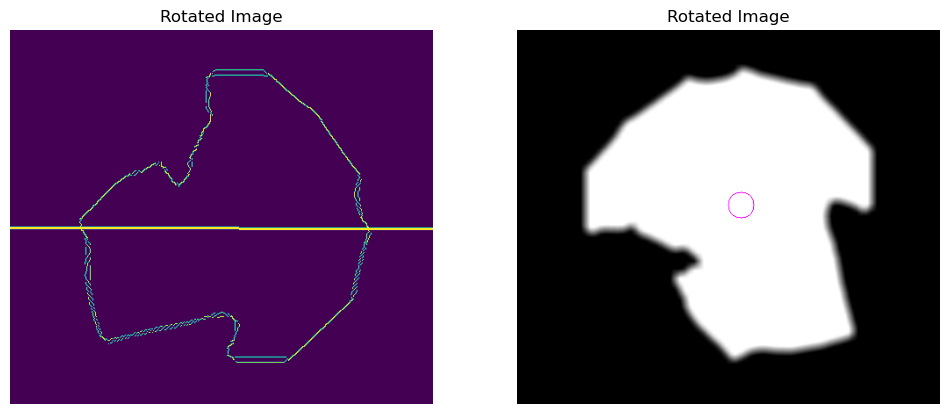

Dominant Direction (in deg): 36.0


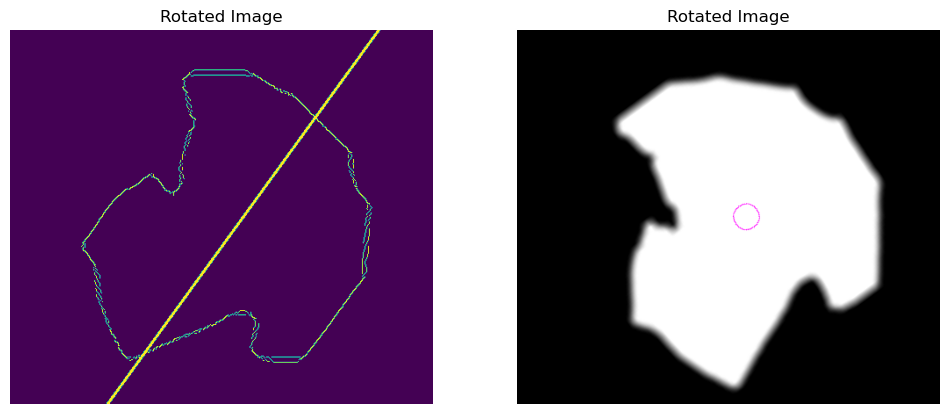

Dominant Direction (in deg): 27.999998


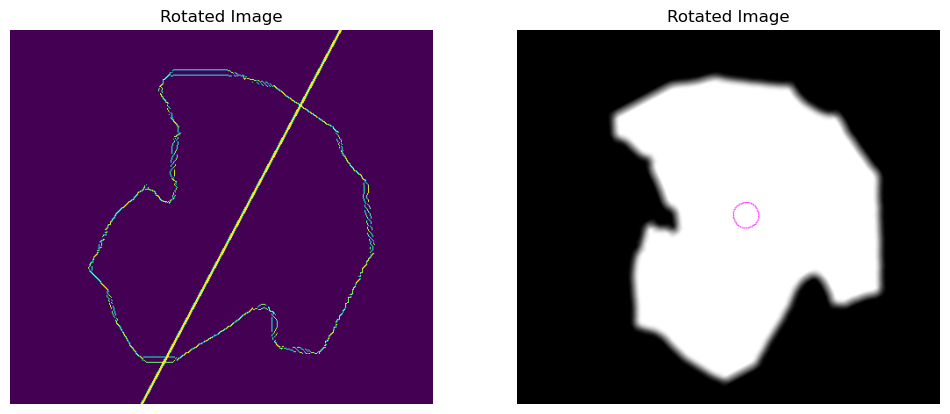

Dominant Direction (in deg): 90.0


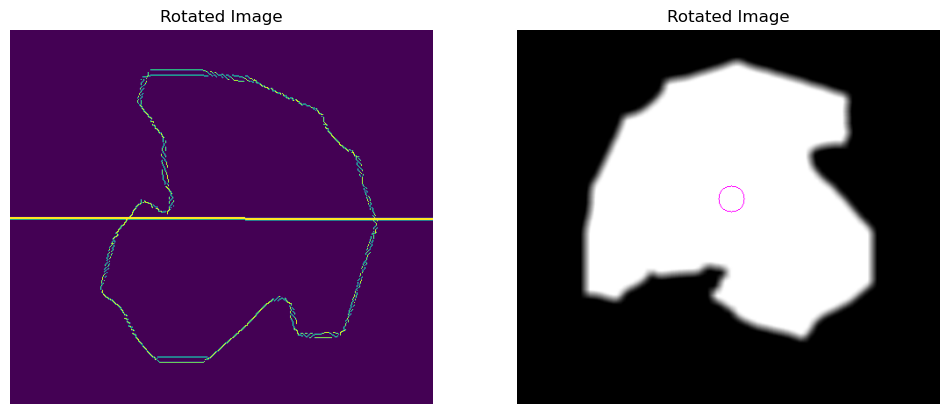

Dominant Direction (in deg): 90.0


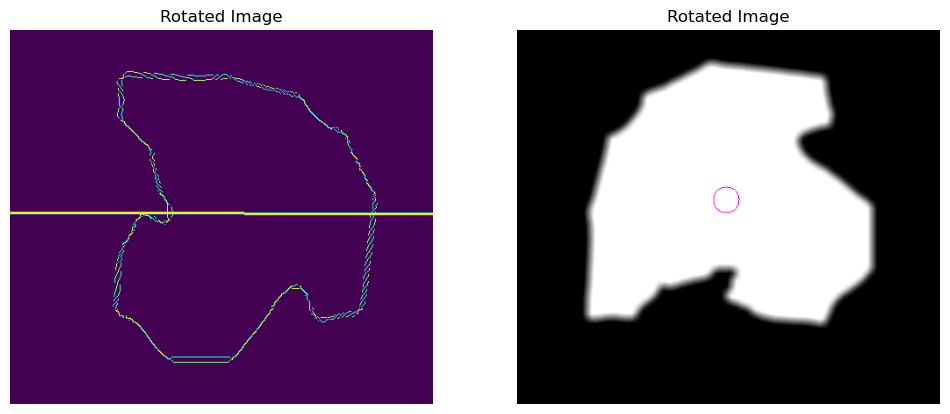

Dominant Direction (in deg): 176.99998


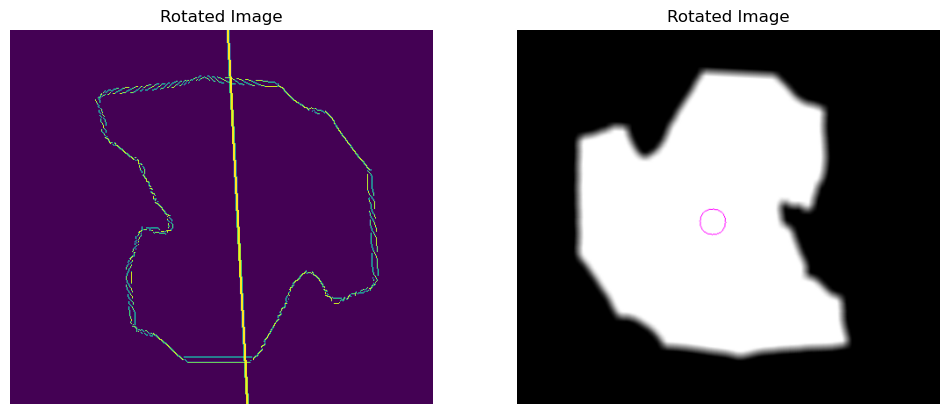

Dominant Direction (in deg): 90.0


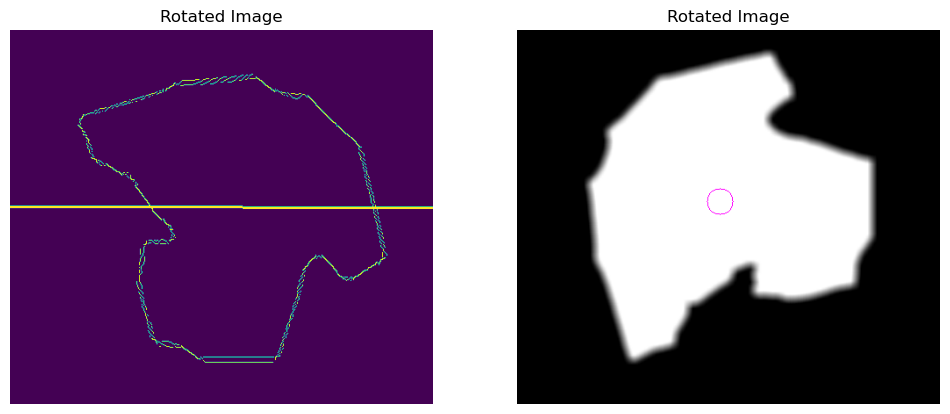

Dominant Direction (in deg): 89.0


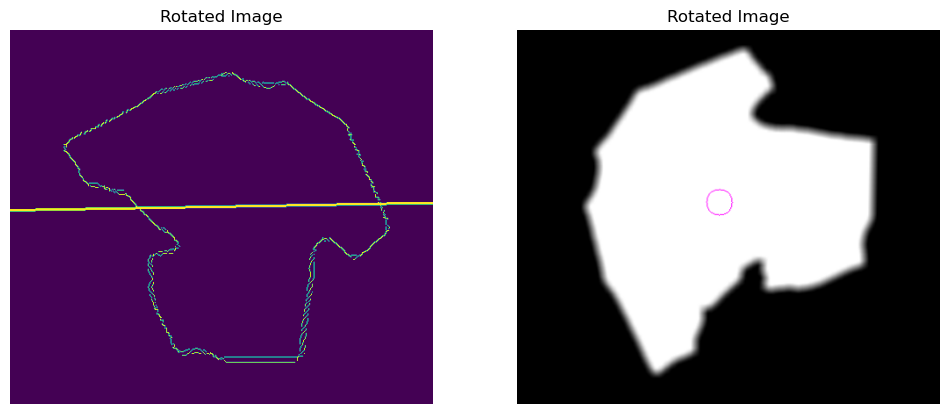

In [119]:

# Convert the colored mask image to grayscale
mask = cropped_mask

# Get the center of the mask image
center = (mask.shape[1] // 2, mask.shape[0] // 2)

# Define the angle steps
angle_step = 10

# Rotate the mask image in 360 degrees with steps of 10 degrees
rotated_masks = []
for angle in range(0, 360, angle_step):
    # Rotate the mask image
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST)
    rotated_masks.append(rotated_mask)

# # Plot the rotated mask samples
# num_samples = len(rotated_masks)
# rows = (num_samples + 4) // 5
# cols = min(num_samples, 5)
# plt.figure(figsize=(cols * 3, rows * 3))

# for i, rotated_mask in enumerate(rotated_masks, start=1):
#     plt.subplot(rows, cols, i)
#     plt.imshow(rotated_mask, cmap='gray')
#     plt.title(f'Rotation: {i * angle_step}°')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()


for rotated_mask in rotated_masks:
    compute_lines(rotated_mask)

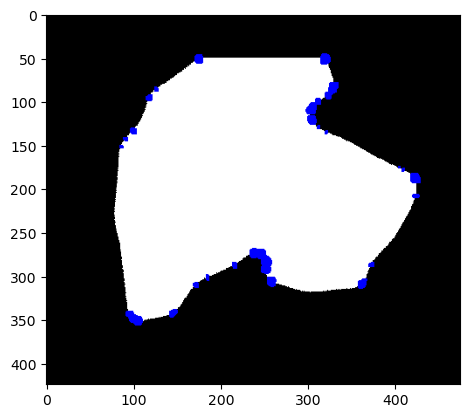

In [110]:
import cv2
import numpy as np

# Load the image
image = cv2.cvtColor(rotated_masks[2], cv2.COLOR_GRAY2BGR)

image = cv2.copyMakeBorder(image, 
                                top=50, 
                                bottom=50, 
                                left=50, 
                                right=50, 
                                borderType=cv2.BORDER_CONSTANT, 
                                value=0)  # Value 0 for black padding


# Convert to float32
gray = np.float32(gray)

# Detect corners
dst = cv2.cornerHarris(gray, blockSize=8, ksize=15, k=0.01)

# Result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
image[dst > 0.01 * dst.max()] = [0, 0, 255]

plt.imshow(image)

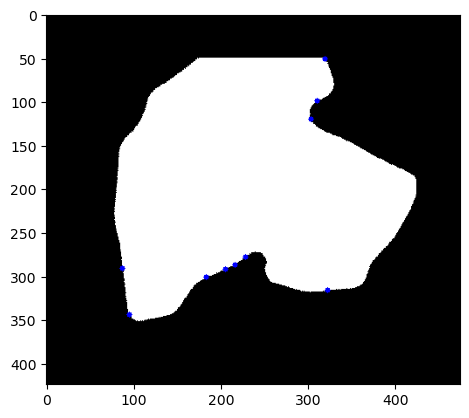

In [98]:
import cv2

# Load the image
image = cv2.cvtColor(rotated_masks[2], cv2.COLOR_GRAY2BGR)

image = cv2.copyMakeBorder(image, 
                                top=50, 
                                bottom=50, 
                                left=50, 
                                right=50, 
                                borderType=cv2.BORDER_CONSTANT, 
                                value=0)  # Value 0 for black padding

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect corners
corners = cv2.goodFeaturesToTrack(gray, maxCorners=10, qualityLevel=0.01, minDistance=10)

# Convert corners to integer
corners = np.int0(corners)

# Draw corners on the image
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

plt.imshow(image)
